In [1]:
import sys
import sqlite3

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV, RFE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [3]:
di = 'SPEI'
di_scale = 9

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
 ]

In [4]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [5]:
# selected_stations = ['Ramsar', 'Nowshahr']
# selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [8]:
cols_to_lag = ['GPM_Precipitation', 'PET_MOD16A2GF', 'NDVI', 'EVI', 'VHI', 'LST', 'PCI_GPM', 'TCI', 'VHI', 'CI_GPM']
for lag in range(1, 13):
    for col in cols_to_lag:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

/tmp/ipykernel_523324/547769836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_523324/547769836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_523324/547769836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [9]:
for col in cols_to_lag:
    # روش محاسبه با استفاده از transform اصلاح شد تا از خطا جلوگیری شود
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    df[f'{col}_roll_mean_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    df[f'{col}_roll_std_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).std())
    df[f'{col}_roll_mean_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).mean())
    df[f'{col}_roll_std_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).std())
    df[f'{col}_roll_mean_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
    df[f'{col}_roll_std_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).std())


/tmp/ipykernel_523324/1391792728.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
/tmp/ipykernel_523324/1391792728.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
/tmp/ipykernel_523324/1391792728.py:5: PerformanceWarning: DataFrame is highly fragmented.  Th

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y_raw = df[f'{di}_{di_scale}_Class']

# y = df[f'{di}_{di_scale}_Class']

# Stacking Meta-Model


Class labels encoded.

--- Performing Automatic Feature Selection with RFECV ---


/tmp/ipykernel_523324/282892639.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
/tmp/ipykernel_523324/282892639.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)


Optimal number of features found by RFECV: 5

Balancing training data with SMOTE...

--- Hyperparameter Tuning for Base Models ---

Tuning rf...
Best params for rf: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 20, 'class_weight': 'balanced'}

Tuning lgbm...


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2637, number of used features: 5
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Number of data points in the train set: 2636, number of used features: 5
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028910 seconds

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params for cat: {'learning_rate': 0.1, 'iterations': 500, 'depth': 8, 'auto_class_weights': 'Balanced'}

Tuning xgb...


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params for xgb: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.05}

Tuning svc...


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for svc: {'svc__gamma': 'scale', 'svc__class_weight': 'balanced', 'svc__C': 10}

Tuning knn...


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for knn: {'kneighborsclassifier__n_neighbors': 5}

--- Building and Training the Final Stacking Model ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3955, number of used features: 5
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Evaluating the Final Model ---


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model Evaluation Metrics (Optimized Stacking Classifier) ---
Accuracy: 0.6920

Classification Report:
              precision    recall  f1-score   support

          ED       0.00      0.00      0.00         3
          EW       1.00      1.00      1.00         1
          MD       0.58      0.48      0.52        23
          MW       0.56      0.61      0.58        38
          NN       0.85      0.78      0.81       141
          SD       0.30      0.55      0.39        11
          VW       0.31      0.57      0.40         7

    accuracy                           0.69       224
   macro avg       0.51      0.57      0.53       224
weighted avg       0.72      0.69      0.70       224



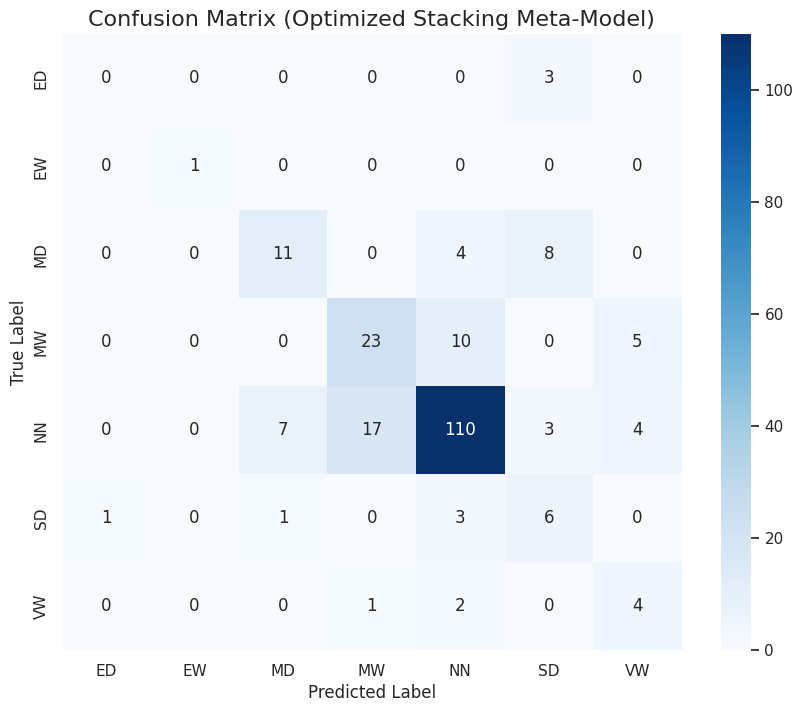

In [11]:
df['Month'] = df['Month'].astype('int')
df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)
df['Month'] = df['Month'].astype('category')
# X.drop(columns=['Month'], inplace=True)


# --- FIX: Encode string labels to integers ---
encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
print("\nClass labels encoded.")

# --- 3. Data Cleaning and Splitting ---
class_counts = pd.Series(y).value_counts()
classes_to_remove_indices = class_counts[class_counts < 2].index
if len(classes_to_remove_indices) > 0:
    # پیدا کردن اندیس های اصلی در دیتافریم
    original_indices_to_remove = df.loc[y_raw.isin(encoder.inverse_transform(classes_to_remove_indices))].index
    print(f"\nRemoving classes with fewer than 2 samples: {list(encoder.inverse_transform(classes_to_remove_indices))}")
    X = X.drop(original_indices_to_remove)
    y = np.delete(y, original_indices_to_remove) # y اکنون یک آرایه نامپای است
    print(f"New data shape after removing rare classes: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 4. Automatic Feature Selection ---
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 15

selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=5, n_jobs=-1)
selector_cv = selector_cv.fit(X_train, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

if optimal_n_features > max_features_cap:
    print(f"Capping features to {max_features_cap}.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train, y_train)
else:
    selector = selector_cv

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_feature_names = X_train.columns[selector.support_] # نام ستون های انتخاب شده


# --- 5. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = pd.Series(y_train).value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# --- 6. Hyperparameter Tuning for Each Base Model ---
print("\n--- Hyperparameter Tuning for Base Models ---")

# تعریف مدل ها و فضای پارامترهای آنها
models_to_tune = {
    'rf': (RandomForestClassifier(random_state=42, n_jobs=-1), {
        'n_estimators': [100, 200, 400], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'class_weight': ['balanced']
    }),
    'lgbm': (LGBMClassifier(random_state=42, n_jobs=-1), {
        'n_estimators': [400], 'learning_rate': [0.1], 'num_leaves': [40], 'class_weight': ['balanced']
    }),
    'cat': (CatBoostClassifier(random_state=42, verbose=0), {
        'iterations': [200, 500], 'learning_rate': [0.05, 0.1], 'depth': [6, 8], 'auto_class_weights': ['Balanced']
    }),
    'xgb': (XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1), {
        'n_estimators': [100, 200, 400], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7]
    }),
    'svc': (make_pipeline(StandardScaler(), SVC(random_state=42, probability=True)), {
        'svc__C': [1, 10], 'svc__gamma': ['scale', 'auto'], 'svc__class_weight': ['balanced']
    }),
    'knn': (make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1)), {
        'kneighborsclassifier__n_neighbors': [5, 7, 9]
    })
}

best_estimators = {}
for name, (model, params) in models_to_tune.items():
    print(f"\nTuning {name}...")
    search = RandomizedSearchCV(model, params, n_iter=10, cv=3, scoring='f1_macro', random_state=42, n_jobs=-1)
    search.fit(X_train_resampled, y_train_resampled)
    best_estimators[name] = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

# --- 7. Build and Train the Final Stacking Meta-Model ---
print("\n--- Building and Training the Final Stacking Model ---")

# استفاده از مدل های بهینه شده
estimators = [
    ('rf', best_estimators['rf']),
    ('lgbm', best_estimators['lgbm']),
    ('cat', best_estimators['cat']),
    ('xgb', best_estimators['xgb']),
    ('svc', best_estimators['svc']),
    ('knn', best_estimators['knn']),
    ('gnb', GaussianNB()) # Naive Bayes نیازی به بهینه سازی ندارد
]

# تعریف مدل نهایی برای ترکیب نتایج
final_estimator = LogisticRegression(random_state=42, class_weight='balanced')

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_resampled, y_train_resampled)

# --- 8. Prediction and Evaluation ---
print("\n--- Evaluating the Final Model ---")
y_pred = stacking_model.predict(X_test_selected)

# برگرداندن برچسب های عددی به رشته ای برای گزارش
y_test_labels = encoder.inverse_transform(y_test)
y_pred_labels = encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels)

print("\n--- Final Model Evaluation Metrics (Optimized Stacking Classifier) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# --- 9. Visualization ---
sns.set_theme(style="whitegrid")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Optimized Stacking Meta-Model)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


